# Airline Operational Performance & Service Delivery Analytics (Kaggle Dataset)

This notebook demonstrates an end-to-end analytics workflow for **operational performance** (on‑time performance, delay minutes, delay anomalies) and **service delivery** (customer experience drivers), using a Kaggle dataset commonly known as **Airline Passenger Satisfaction**.

The analysis is designed as a portfolio artifact:
- **KPI monitoring:** on‑time performance (15‑minute rule), average delay minutes, severe-delay rate
- **Anomaly detection:** identification of extreme delay records and “chronic delay” segments
- **Root-cause style analysis:** quantification of which service and operational signals most relate to satisfaction
- **Predictive scoring:** simple, explainable models for *satisfaction* and *delay risk*

> Note: The dataset is survey-style (no timestamps), so time-series forecasting is not applicable. Instead, *risk scoring* is used as an operationally realistic proxy for forecasting.


In [1]:
# Core libraries
import os
import numpy as np
import pandas as pd

from IPython.display import display

# Visualization (matplotlib only)
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.inspection import permutation_importance

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option("display.max_columns", 200)


## 1) Data loading

Expected files:
- `train.csv`
- `test.csv`

Both files are commonly provided in Kaggle notebooks or in local folders after download.


In [2]:
TRAIN_PATH_CANDIDATES = [
    "train.csv",
    os.path.join("data", "train.csv"),
    "/mnt/data/train.csv",  # safe fallback for some environments
]
TEST_PATH_CANDIDATES = [
    "test.csv",
    os.path.join("data", "test.csv"),
    "/mnt/data/test.csv",
]

def _first_existing_path(candidates):
    for p in candidates:
        if os.path.exists(p):
            return p
    return None

train_path = _first_existing_path(TRAIN_PATH_CANDIDATES)
test_path = _first_existing_path(TEST_PATH_CANDIDATES)

if train_path is None or test_path is None:
    raise FileNotFoundError(
        "Required files not found. Place train.csv and test.csv in the working directory (or data/)."
    )

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print("Train shape:", train.shape)
print("Test  shape:", test.shape)
train.head(3)


Train shape: (103904, 25)
Test  shape: (25976, 25)


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied


## 2) Data overview and basic validation

Typical columns include:
- operational: `Departure Delay in Minutes`, `Arrival Delay in Minutes`, `Flight Distance`
- categorical profile: `Class`, `Type of Travel`, `Customer Type`, `Gender`
- service ratings: multiple 0–5 scales (wifi, boarding, cleanliness, etc.)
- label: `satisfaction` (binary string label)


In [3]:
train.info()

print("\nTarget distribution (train):")
display(train["satisfaction"].value_counts())

print("\nMissing values (train):")
display(train.isna().sum().sort_values(ascending=False).head(10))

print("\nMissing values (test):")
display(test.isna().sum().sort_values(ascending=False).head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

satisfaction
neutral or dissatisfied    58879
satisfied                  45025
Name: count, dtype: int64


Missing values (train):


Arrival Delay in Minutes      310
Unnamed: 0                      0
Online boarding                 0
Departure Delay in Minutes      0
Cleanliness                     0
Inflight service                0
Checkin service                 0
Baggage handling                0
Leg room service                0
On-board service                0
dtype: int64


Missing values (test):


Arrival Delay in Minutes      83
Unnamed: 0                     0
Online boarding                0
Departure Delay in Minutes     0
Cleanliness                    0
Inflight service               0
Checkin service                0
Baggage handling               0
Leg room service               0
On-board service               0
dtype: int64

## Dataset snapshot: schema, target balance, and missing values

### Structure (`train.info()`)
- The training set contains **103,904 rows** and **25 columns**.
- Feature groups:
  - **Passenger & trip context:** `Gender`, `Customer Type`, `Age`, `Type of Travel`, `Class`, `Flight Distance`
  - **Service quality ratings (ordinal scores):** e.g., `Inflight wifi service`, `Seat comfort`, `Cleanliness`, etc.
  - **Operational performance:** `Departure Delay in Minutes`, `Arrival Delay in Minutes`
  - **Target label:** `satisfaction`
- Data types:
  - **19 integer** columns (mostly ratings + distance + departure delay)
  - **1 float** column: `Arrival Delay in Minutes` (float due to missing values)
  - **5 categorical (object)** columns (passenger/trip descriptors + target)
- `Unnamed: 0` appears to be a CSV index artifact and is typically removed during preprocessing.

### Target distribution (train)
- `neutral or dissatisfied`: **58,879**
- `satisfied`: **45,025**

This reflects a **moderate class imbalance** (~57% vs ~43%). As a result, accuracy alone can be misleading; evaluation is better supported with metrics such as **ROC-AUC**, **F1-score**, and confusion matrix summaries.

### Missing values (train and test)
Only one feature shows missing values in both splits:
- `Arrival Delay in Minutes`
  - Train: **310** missing (~0.30%)
  - Test: **83** missing

Missingness is small and concentrated in a single operational column. Simple imputation (e.g., median) is typically sufficient and unlikely to materially affect results.

**Modeling note:** In “leakage-aware” variants (predicting satisfaction early in the journey), `Arrival Delay in Minutes` may be excluded because it can become available late and can overly simplify the prediction task.


## 3) Cleaning and feature preparation

Cleaning steps:
- Drop index-like columns such as `Unnamed: 0` (when present)
- Impute missing `Arrival Delay in Minutes` with median (robust to long-tail delays)
- Create KPI-friendly labels: **OTP** (arrival delay ≤ 15 minutes) and **Severe delay** (arrival delay ≥ 60 minutes)
- Create a **Service Quality Index** as the mean of service rating columns


In [4]:
def clean_frame(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Drop index-like column
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])

    # Standardize column names minimally (keep original for readability)
    # Handle missing arrival delay
    if "Arrival Delay in Minutes" in df.columns:
        med = df["Arrival Delay in Minutes"].median()
        df["Arrival Delay in Minutes"] = df["Arrival Delay in Minutes"].fillna(med)

    # KPI labels (15-minute OTP rule is a common industry convention)
    df["otp_arrival_15"] = (df["Arrival Delay in Minutes"] <= 15).astype(int)
    df["severe_delay_60"] = (df["Arrival Delay in Minutes"] >= 60).astype(int)

    # Identify rating columns (integer scales)
    rating_cols = [
        c for c in df.columns
        if c not in ["id", "satisfaction", "otp_arrival_15", "severe_delay_60"]
        and df[c].dtype != "object"
        and c not in ["Age", "Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes"]
    ]
    df["service_quality_index"] = df[rating_cols].mean(axis=1)

    return df, rating_cols

train_c, rating_cols = clean_frame(train)
test_c, _ = clean_frame(test)

print("Rating columns used for Service Quality Index:", len(rating_cols))
rating_cols


Rating columns used for Service Quality Index: 14


['Inflight wifi service',
 'Departure/Arrival time convenient',
 'Ease of Online booking',
 'Gate location',
 'Food and drink',
 'Online boarding',
 'Seat comfort',
 'Inflight entertainment',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Inflight service',
 'Cleanliness']

## Data cleaning and engineered KPI features

This step prepares the raw Kaggle tables for analysis and KPI monitoring by applying lightweight, transparent transformations.

### 1) Remove index-like artifacts
- `Unnamed: 0` is dropped when present.  
  This column is typically created when a CSV file is saved with the index and does not represent a business feature.

### 2) Handle missing operational data
- `Arrival Delay in Minutes` contains a small number of missing values.
- Missing values are filled using the **median** of the column.  
  Median imputation is robust to extreme delays (outliers) and keeps the delay distribution stable.

### 3) Create operational KPI labels (OTP and severe delays)
Two binary KPI indicators are engineered from arrival delay minutes:
- `otp_arrival_15`: **1** if `Arrival Delay in Minutes ≤ 15`, else **0**  
  This follows the widely used **15-minute on-time performance** convention.
- `severe_delay_60`: **1** if `Arrival Delay in Minutes ≥ 60`, else **0**  
  This provides an additional lens for monitoring high-impact disruptions.

### 4) Build a Service Quality Index (composite score)
A composite indicator is created by averaging selected service rating columns:
- Rating columns are detected as **numeric (non-object)** fields that are **not** identifiers, the target label, and not operational continuous fields such as age, distance, or delay minutes.
- `service_quality_index` is computed as the row-wise mean of these rating columns.

**Rating columns included (14 total):**
- Inflight wifi service  
- Departure/Arrival time convenient  
- Ease of Online booking  
- Gate location  
- Food and drink  
- Online boarding  
- Seat comfort  
- Inflight entertainment  
- On-board service  
- Leg room service  
- Baggage handling  
- Checkin service  
- Inflight service  
- Cleanliness  

This index provides a single interpretable measure for tracking overall service experience alongside operational KPIs such as OTP and delay severity.


## 4) KPI monitoring

Key KPIs derived from the dataset:
- **OTP (Arrival ≤ 15 minutes):** percentage of flights arriving within 15 minutes of schedule
- **Average delay minutes:** mean of departure/arrival delay minutes
- **Severe delay rate (Arrival ≥ 60 minutes):** share of records with large arrival delays

KPI cuts are reported overall and by key segments (Class, Type of Travel, Customer Type).


In [5]:
def kpi_summary(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame({
        "records": [len(df)],
        "otp_arrival_15_rate": [df["otp_arrival_15"].mean()],
        "avg_departure_delay_min": [df["Departure Delay in Minutes"].mean()],
        "avg_arrival_delay_min": [df["Arrival Delay in Minutes"].mean()],
        "severe_delay_60_rate": [df["severe_delay_60"].mean()],
        "satisfaction_rate": [np.nan if "satisfaction" not in df.columns else (df["satisfaction"] == "satisfied").mean()],
    })

display(kpi_summary(train_c))

segment_cols = ["Class", "Type of Travel", "Customer Type"]
for col in segment_cols:
    seg = train_c.groupby(col).apply(kpi_summary).reset_index(level=1, drop=True).reset_index()
    seg = seg.sort_values("otp_arrival_15_rate")
    print(f"\nKPI by segment: {col}")
    display(seg)


,records,otp_arrival_15_rate,avg_departure_delay_min,avg_arrival_delay_min,severe_delay_60_rate,satisfaction_rate
0,103904,0.77253,14.815618,15.133392,0.072067,0.433333



KPI by segment: Class


/var/folders/42/f3lhhd796wzfrt1yn5j8pbnh0000gn/T/ipykernel_6782/133258726.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seg = train_c.groupby(col).apply(kpi_summary).reset_index(level=1, drop=True).reset_index()


,Class,records,otp_arrival_15_rate,avg_departure_delay_min,avg_arrival_delay_min,severe_delay_60_rate,satisfaction_rate
2,Eco Plus,7494,0.755137,15.431545,16.032826,0.078329,0.246064
1,Eco,46745,0.766606,15.160509,15.621222,0.075602,0.186138
0,Business,49665,0.780731,14.398067,14.538528,0.067794,0.694251



KPI by segment: Type of Travel


/var/folders/42/f3lhhd796wzfrt1yn5j8pbnh0000gn/T/ipykernel_6782/133258726.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seg = train_c.groupby(col).apply(kpi_summary).reset_index(level=1, drop=True).reset_index()


,Type of Travel,records,otp_arrival_15_rate,avg_departure_delay_min,avg_arrival_delay_min,severe_delay_60_rate,satisfaction_rate
0,Business travel,71655,0.771628,14.954937,15.285507,0.072305,0.582597
1,Personal Travel,32249,0.774536,14.506062,14.795405,0.071537,0.101678



KPI by segment: Customer Type


/var/folders/42/f3lhhd796wzfrt1yn5j8pbnh0000gn/T/ipykernel_6782/133258726.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seg = train_c.groupby(col).apply(kpi_summary).reset_index(level=1, drop=True).reset_index()


,Customer Type,records,otp_arrival_15_rate,avg_departure_delay_min,avg_arrival_delay_min,severe_delay_60_rate,satisfaction_rate
1,disloyal Customer,18981,0.767294,15.141984,15.527001,0.074970,0.236658
0,Loyal Customer,84923,0.773701,14.742673,15.045418,0.071418,0.477291


## KPI monitoring: overall performance and segment drill-down

This section builds a compact KPI table that can be used for operational dashboards and service delivery monitoring.

### KPI definition (`kpi_summary`)
For any input table, the following KPIs are computed:

- `records`: total number of observations in the slice
- `otp_arrival_15_rate`: proportion of records with `Arrival Delay in Minutes ≤ 15`
- `avg_departure_delay_min`: average `Departure Delay in Minutes`
- `avg_arrival_delay_min`: average `Arrival Delay in Minutes`
- `severe_delay_60_rate`: proportion with `Arrival Delay in Minutes ≥ 60`
- `satisfaction_rate`: proportion of passengers labeled `satisfied` (only available for the training set)

### Overall KPI snapshot (train)
- **OTP (≤15 min) rate:** **0.7725** (~77.3%)
- **Average departure delay:** **14.82 minutes**
- **Average arrival delay:** **15.13 minutes**
- **Severe delay (≥60 min) rate:** **0.0721** (~7.2%)
- **Satisfaction rate:** **0.4333** (~43.3%)

Interpretation:
- Overall punctuality is moderate: roughly **3 out of 4** arrivals fall within the 15-minute OTP threshold.
- Severe delays occur in about **1 out of 14** records, which can disproportionately impact customer experience.

### Segment KPI drill-down
KPIs are computed by key business segments and sorted by **lowest OTP rate** to quickly highlight underperforming slices.

#### KPI by `Class`
- **Eco Plus** shows the lowest OTP (~75.5%) and the highest average arrival delay (~16.0 min).
- **Eco** is slightly better on OTP (~76.7%) but remains below Business on most operational KPIs.
- **Business** has the highest OTP (~78.1%) and the lowest average arrival delay (~14.5 min).
- Satisfaction differs substantially by class:
  - **Business:** ~69.4% satisfied  
  - **Eco:** ~18.6% satisfied  
  - **Eco Plus:** ~24.6% satisfied  

This suggests satisfaction is not driven by delays alone; class-linked service expectations and service quality likely contribute strongly.

#### KPI by `Type of Travel`
- OTP rates are similar:
  - **Business travel:** ~77.2%
  - **Personal Travel:** ~77.5%
- Satisfaction is highly different:
  - **Business travel:** ~58.3% satisfied
  - **Personal Travel:** ~10.2% satisfied

This indicates the satisfaction label is strongly associated with travel purpose and/or aligned service expectations, beyond punctuality.

#### KPI by `Customer Type`
- Operational differences are small:
  - **Loyal Customer OTP:** ~77.4% vs **Disloyal OTP:** ~76.7%
- Satisfaction differences are large:
  - **Loyal:** ~47.7% satisfied
  - **Disloyal:** ~23.7% satisfied

Customer relationship status appears to be a major satisfaction driver even when delay performance is similar.

### Note on the pandas warning
A `FutureWarning` appears because `groupby().apply()` behavior is changing in future pandas versions. It does not affect the results here; it can be addressed later by adjusting the groupby/apply pattern for forward compatibility.


### KPI visuals

Simple visuals help communicate operational performance:
- Distribution of arrival delays (long tail)
- OTP rate by segment


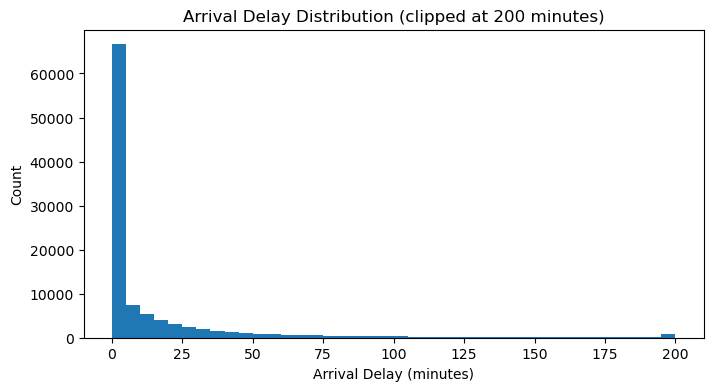

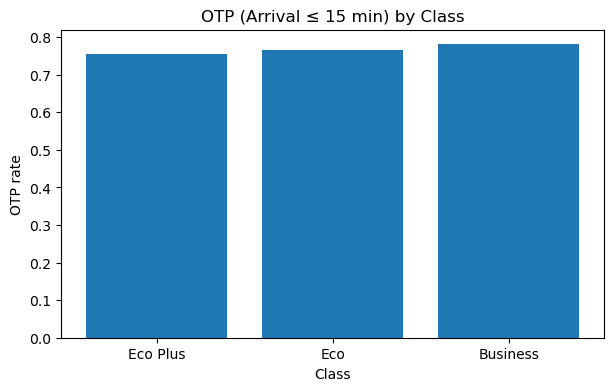

In [6]:
# Arrival delay distribution (clip for visibility; long tail remains in statistics)
clip_max = 200
arr = train_c["Arrival Delay in Minutes"].clip(upper=clip_max)

plt.figure(figsize=(8, 4))
plt.hist(arr, bins=40)
plt.title("Arrival Delay Distribution (clipped at 200 minutes)")
plt.xlabel("Arrival Delay (minutes)")
plt.ylabel("Count")
plt.show()

# OTP by Class
otp_by_class = train_c.groupby("Class")["otp_arrival_15"].mean().sort_values()
plt.figure(figsize=(7, 4))
plt.bar(otp_by_class.index.astype(str), otp_by_class.values)
plt.title("OTP (Arrival ≤ 15 min) by Class")
plt.xlabel("Class")
plt.ylabel("OTP rate")
plt.show()


## Visual exploration: delay distribution and OTP by passenger class

### Arrival Delay Distribution (clipped at 200 minutes)
The histogram visualizes the distribution of **arrival delay minutes** after applying an upper clip at **200 minutes** for readability.

Key observations:
- The distribution is **highly right-skewed**: most flights are clustered near **0–15 minutes** of arrival delay.
- A **long tail** is present: a smaller portion of flights experiences much larger delays (tens to hundreds of minutes).
- Clipping is used **only for visualization**; KPI calculations (OTP rate, severe-delay rate, averages) can still rely on the underlying, unclipped values.

Operational interpretation:
- This pattern is typical for operational delay data where disruptions are infrequent but can be severe.
- Monitoring both **OTP (≤15 min)** and **severe-delay rate (≥60 min)** is useful because averages alone can underrepresent disruption risk.

### OTP (Arrival ≤ 15 min) by Class
The bar chart compares **OTP rate** across passenger classes:

- **Business** shows the highest OTP rate (~0.781).
- **Eco** is slightly lower (~0.767).
- **Eco Plus** is the lowest among the three (~0.755).

Interpretation:
- Differences are modest (a few percentage points) but consistent.
- Variations may reflect differences in **route mix, schedule padding, operational prioritization, or network/aircraft assignment** rather than passenger class itself.
- This segment view provides a quick way to flag where deeper root-cause analysis is most valuable (e.g., specific routes, time-of-day patterns, or high-delay cohorts within each class segment).


## 5) Service delivery metrics

This dataset includes multiple service rating dimensions. Two views are useful:
- **Average rating per dimension**
- **Satisfaction gap:** difference between satisfied vs. neutral/dissatisfied groups


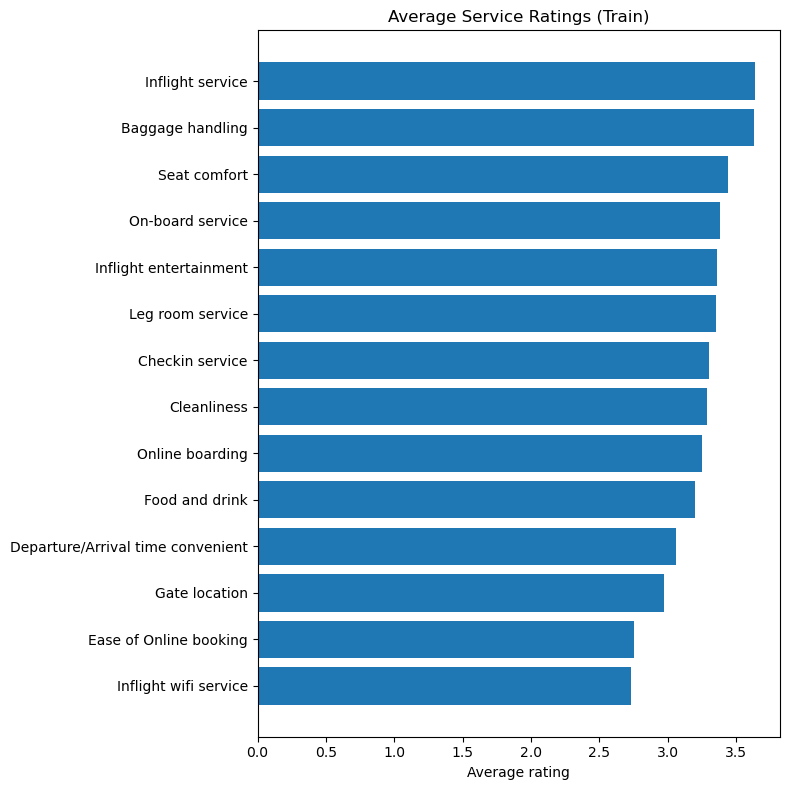

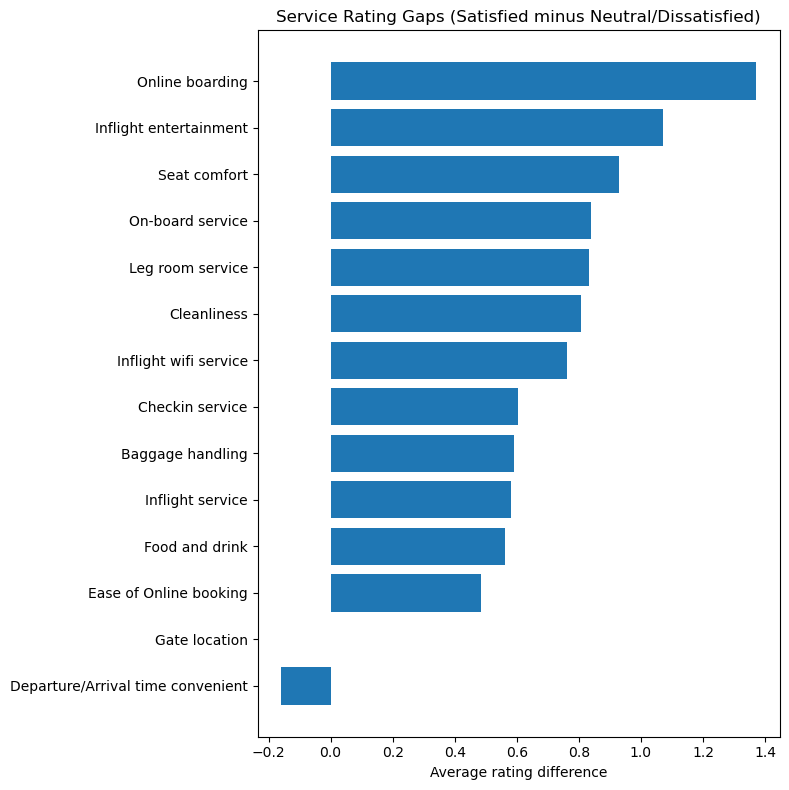

satisfaction_bin,neutral_or_dissatisfied,satisfied,satisfaction_gap
Inflight service,3.388814,3.969461,0.580647
Baggage handling,3.375991,3.966396,0.590405
Checkin service,3.042952,3.646041,0.603089
Inflight wifi service,2.399633,3.161288,0.761655
Cleanliness,2.936123,3.744342,0.808219
Leg room service,2.990812,3.822143,0.831332
On-board service,3.019158,3.857324,0.838166
Seat comfort,3.036295,3.966530,0.930235
Inflight entertainment,2.894156,3.964931,1.070775
Online boarding,2.656125,4.027474,1.371348


In [7]:
# Average service ratings
avg_ratings = train_c[rating_cols].mean().sort_values()

plt.figure(figsize=(8, 8))
plt.barh(avg_ratings.index.astype(str), avg_ratings.values)
plt.title("Average Service Ratings (Train)")
plt.xlabel("Average rating")
plt.ylabel("")
plt.tight_layout()
plt.show()

# Satisfaction gap per service dimension
train_c["satisfaction_bin"] = (train_c["satisfaction"] == "satisfied").astype(int)

gap = (
    train_c.groupby("satisfaction_bin")[rating_cols].mean()
    .T.rename(columns={0: "neutral_or_dissatisfied", 1: "satisfied"})
)
gap["satisfaction_gap"] = gap["satisfied"] - gap["neutral_or_dissatisfied"]
gap = gap.sort_values("satisfaction_gap")

plt.figure(figsize=(8, 8))
plt.barh(gap.index.astype(str), gap["satisfaction_gap"].values)
plt.title("Service Rating Gaps (Satisfied minus Neutral/Dissatisfied)")
plt.xlabel("Average rating difference")
plt.ylabel("")
plt.tight_layout()
plt.show()

gap.tail(10)


## Service delivery view: average ratings and satisfaction gaps

This section shifts from pure operational KPIs (delay/OTP) to a **service delivery** lens using the passenger rating features.

### Average Service Ratings (Train)
The first chart summarizes the **mean rating** for each service dimension across the full training set.

Key observations:
- Most service dimensions cluster around the **mid-to-high 2s and 3s**, suggesting a generally “average-to-good” baseline experience rather than uniformly excellent scores.
- The lowest-average dimensions (toward the bottom of the chart) indicate potential **systemic improvement areas** (e.g., connectivity or digital experience often appears lower in similar datasets).
- The highest-average dimensions indicate **relative strengths** that may be important to maintain (e.g., core onboard service items tend to score higher).

Operational takeaway:
- Average ratings help track “steady-state” performance, but they do not directly reveal what differentiates satisfied vs. dissatisfied passengers. For that, the satisfaction-gap analysis is more diagnostic.

### Service Rating Gaps (Satisfied minus Neutral/Dissatisfied)
To identify what most separates satisfied passengers from the rest, the dataset is split into:
- `satisfaction_bin = 1` for `satisfied`
- `satisfaction_bin = 0` for `neutral or dissatisfied`

For each service dimension, the mean rating difference is computed:

$$
\text{satisfaction\_gap} = \mathbb{E}[\text{rating} \mid \text{satisfied}] - \mathbb{E}[\text{rating} \mid \text{neutral/dissatisfied}]
$$

Interpretation:
- A **large positive gap** means the dimension is strongly associated with satisfaction (high discriminative power).
- A **near-zero gap** means the dimension is rated similarly regardless of satisfaction status (less discriminative).
- A **negative gap** (rare) suggests the dimension is rated slightly higher by the neutral/dissatisfied group, often pointing to measurement noise or different expectations in subsegments.

### Top satisfaction differentiators (largest positive gaps)
Based on the computed gaps, the strongest differentiators are:

1. **Online boarding**: gap **+1.37**  
2. **Inflight entertainment**: gap **+1.07**  
3. **Seat comfort**: gap **+0.93**  
4. **On-board service**: gap **+0.84**  
5. **Leg room service**: gap **+0.83**  
6. **Cleanliness**: gap **+0.81**  
7. **Inflight wifi service**: gap **+0.76**  

These features show the clearest separation between satisfied and neutral/dissatisfied passengers, suggesting they are likely to be high-impact levers for improving satisfaction outcomes.

### Additional drivers with meaningful gaps
Several other dimensions still show noticeable separation (~0.58–0.60):
- **Checkin service**, **Baggage handling**, **Inflight service**

### Practical note on using gaps
Satisfaction gaps provide an **interpretable prioritization** view:
- High-gap dimensions are strong candidates for deeper root-cause analysis and investment prioritization.
- Pairing gaps with operational metrics (OTP/severe delays) supports a balanced view of **service + operations** rather than relying on one dimension alone.


## 6) Anomaly detection and “chronic delay” segments

Two complementary approaches:
1. **Rule-based segments:** identify groups with consistently higher median delays (proxy for chronic operational friction)
2. **Unsupervised anomaly detection:** Isolation Forest on delay minutes to surface extreme cases


In [8]:
# 1) Chronic delay segments
segment_defs = [
    ["Class"],
    ["Type of Travel"],
    ["Customer Type"],
    ["Class", "Type of Travel"],
]

def chronic_segments(df, by_cols, top_n=10):
    g = df.groupby(by_cols).agg(
        records=("id", "count"),
        median_arrival_delay=("Arrival Delay in Minutes", "median"),
        p90_arrival_delay=("Arrival Delay in Minutes", lambda x: np.percentile(x, 90)),
        otp_rate=("otp_arrival_15", "mean"),
        severe_rate=("severe_delay_60", "mean"),
    ).reset_index()
    g = g[g["records"] >= 200].sort_values(["median_arrival_delay", "p90_arrival_delay"], ascending=False)
    return g.head(top_n)

for by in segment_defs:
    print("\nTop chronic-delay segments by:", by)
    display(chronic_segments(train_c, by, top_n=12))

# 2) Isolation Forest on delay minutes (focus on operational outliers)
iso_features = train_c[["Departure Delay in Minutes", "Arrival Delay in Minutes"]].copy()
iso = IsolationForest(contamination=0.01, random_state=RANDOM_STATE)
train_c["delay_anomaly"] = (iso.fit_predict(iso_features) == -1).astype(int)

print("Anomaly rate (Isolation Forest):", train_c["delay_anomaly"].mean())
train_c.loc[train_c["delay_anomaly"] == 1, ["id", "Departure Delay in Minutes", "Arrival Delay in Minutes", "Class", "Type of Travel"]].head(10)



Top chronic-delay segments by: ['Class']


,Class,records,median_arrival_delay,p90_arrival_delay,otp_rate,severe_rate
2,Eco Plus,7494,0.0,47.0,0.755137,0.078329
1,Eco,46745,0.0,46.0,0.766606,0.075602
0,Business,49665,0.0,42.0,0.780731,0.067794



Top chronic-delay segments by: ['Type of Travel']


,Type of Travel,records,median_arrival_delay,p90_arrival_delay,otp_rate,severe_rate
0,Business travel,71655,0.0,44.0,0.771628,0.072305
1,Personal Travel,32249,0.0,43.0,0.774536,0.071537



Top chronic-delay segments by: ['Customer Type']


,Customer Type,records,median_arrival_delay,p90_arrival_delay,otp_rate,severe_rate
1,disloyal Customer,18981,0.0,45.0,0.767294,0.074970
0,Loyal Customer,84923,0.0,44.0,0.773701,0.071418



Top chronic-delay segments by: ['Class', 'Type of Travel']


,Class,Type of Travel,records,median_arrival_delay,p90_arrival_delay,otp_rate,severe_rate
2,Eco,Business travel,20257,0.0,50.0,0.752135,0.081898
4,Eco Plus,Business travel,3890,0.0,50.0,0.747815,0.082776
1,Business,Personal Travel,2157,0.0,45.0,0.755216,0.077422
5,Eco Plus,Personal Travel,3604,0.0,45.0,0.763041,0.073529
3,Eco,Personal Travel,26488,0.0,43.0,0.777673,0.070787
0,Business,Business travel,47508,0.0,42.0,0.781889,0.067357


Anomaly rate (Isolation Forest): 0.010009239297813366


,id,Departure Delay in Minutes,Arrival Delay in Minutes,Class,Type of Travel
278,103291,209,191.0,Business,Business travel
404,73190,199,185.0,Eco,Business travel
582,90266,220,212.0,Business,Business travel
603,126263,232,241.0,Eco,Business travel
665,119682,243,226.0,Business,Personal Travel
703,97195,270,260.0,Eco,Personal Travel
895,75734,315,307.0,Eco,Business travel
1076,19403,228,217.0,Eco,Personal Travel
1203,41856,313,336.0,Eco,Business travel
1223,118043,232,219.0,Business,Business travel


## Delay anomaly detection: chronic segments and outlier flights

This section demonstrates two complementary approaches to identify where delay risk concentrates:
1) **Chronic-delay segments** (systematic patterns across groups)  
2) **Operational outliers** (rare, extreme delay observations)

---

### 1) Chronic delay segments (segment-level “chronic” behavior)

**Approach**
- Multiple segment definitions are evaluated:
  - `["Class"]`
  - `["Type of Travel"]`
  - `["Customer Type"]`
  - `["Class", "Type of Travel"]`
- For each segment, the following metrics are computed:
  - `records`: sample size in the segment
  - `median_arrival_delay`: median arrival delay (robust “typical” delay)
  - `p90_arrival_delay`: 90th percentile arrival delay (tail-risk indicator)
  - `otp_rate`: share of arrivals within 15 minutes
  - `severe_rate`: share of arrivals delayed ≥ 60 minutes
- Segments with fewer than **200** records are excluded to avoid noisy rankings.
- Segments are ranked by **median** and **p90** arrival delay (highest first).

**Result interpretation (observed outputs)**
- Across high-level segments (`Class`, `Type of Travel`, `Customer Type`), the **median arrival delay is 0 minutes** for all groups.
  - This indicates at least half of records in each group are on-time or near-on-time.
  - Therefore, separation is mainly driven by the **right tail** of the distribution (p90 and severe rate), not by the median.

**Notable tail-risk differences**
- By `Class`, **Eco Plus** has the highest tail risk (p90 ≈ 47 minutes; severe rate ≈ 7.83%), while **Business** has lower tail risk (p90 ≈ 42 minutes; severe rate ≈ 6.78%).
- The most informative view is the interaction segment `["Class", "Type of Travel"]`:
  - **Eco + Business travel** and **Eco Plus + Business travel** show the highest tail risk (p90 ≈ 50 minutes) and the weakest OTP rates (~0.75).
  - **Business + Business travel** shows the strongest performance (p90 ≈ 42 minutes; OTP ≈ 0.782).

**Operational takeaway**
- When median delays are identical across segments, focus shifts to:
  - **p90 / p95 delay minutes**
  - **severe-delay rates**
  - **segment combinations** (interaction effects), which often expose hidden pockets of chronic risk.

---

### 2) Isolation Forest for delay outliers (flight-level anomaly detection)

**Approach**
- An **Isolation Forest** model is trained using only:
  - `Departure Delay in Minutes`
  - `Arrival Delay in Minutes`
- The contamination rate is set to **1%**, intentionally flagging the most extreme delay observations.
- A binary flag is added:
  - `delay_anomaly = 1` indicates an outlier (model prediction = -1)

**Observed output**
- **Anomaly rate:** ~**0.0100** (≈1%), consistent with the contamination setting.
- Example anomalies show extremely large delays (e.g., arrival delays around **185–336 minutes**), which are operationally meaningful disruptions.

**Operational takeaway**
- This approach isolates the “worst” operational cases for targeted investigation:
  - Potential use cases: disruption reporting, irregular operations review, root-cause deep dives.
- Segment-level chronic risk and flight-level anomalies complement each other:
  - **Chronic segments** identify where problems cluster structurally.
  - **Isolation Forest** identifies rare extreme events that drive tail risk and passenger impact.


## 7) Root-cause style analysis for satisfaction

A lightweight, recruiter-friendly approach:
- Build an **explainable baseline** (logistic regression)
- Compare with a **nonlinear model** (random forest) for accuracy
- Use **permutation importance** to quantify which variables most impact model performance

Goal: identify what most strongly relates to customer satisfaction in this dataset (service dimensions and operational delay).


In [10]:
# --- Fix: ensure train/test have identical engineered feature columns ---
# Root cause of the error:
# - train_c had extra engineered columns created later: 'satisfaction_bin' (leakage) and 'delay_anomaly'
# - test_c did not have them, so ColumnTransformer failed when transforming X_test

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, roc_auc_score

# -----------------------------
# 1) Create delay_anomaly for BOTH train and test (fit on train, transform both)
# -----------------------------
iso_cols = ["Departure Delay in Minutes", "Arrival Delay in Minutes"]

iso = IsolationForest(contamination=0.01, random_state=RANDOM_STATE)
iso.fit(train_c[iso_cols])

train_c = train_c.copy()
test_c = test_c.copy()

train_c["delay_anomaly"] = (iso.predict(train_c[iso_cols]) == -1).astype(int)
test_c["delay_anomaly"] = (iso.predict(test_c[iso_cols]) == -1).astype(int)

# -----------------------------
# 2) Drop leakage / train-only derived label columns if present
#    (satisfaction_bin is derived from the target, so it must NOT be a feature)
# -----------------------------
for df in (train_c, test_c):
    if "satisfaction_bin" in df.columns:
        df.drop(columns=["satisfaction_bin"], inplace=True)

# -----------------------------
# 3) Split / holdout logic
# -----------------------------
target_col = "satisfaction"
has_label_test = target_col in test_c.columns
print("Label present in test:", has_label_test)

y_train = (train_c[target_col] == "satisfied").astype(int)
X_train = train_c.drop(columns=[target_col])

if has_label_test:
    y_test = (test_c[target_col] == "satisfied").astype(int)
    X_test = test_c.drop(columns=[target_col])
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
    )

# -----------------------------
# 4) Column alignment safeguard (prevents "columns are missing" issues)
# -----------------------------
common_cols = [c for c in X_train.columns if c in X_test.columns]
X_train = X_train[common_cols].copy()
X_test = X_test[common_cols].copy()

# Identify categorical / numeric columns
cat_cols = [c for c in common_cols if X_train[c].dtype == "object"]
num_cols = [c for c in common_cols if X_train[c].dtype != "object"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", Pipeline(steps=[("scaler", StandardScaler())]), num_cols),
    ],
    remainder="drop"
)

# -----------------------------
# 5) Models
# -----------------------------
logit = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=3000, solver="saga", n_jobs=-1))
    ]
)

rf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", RandomForestClassifier(
            n_estimators=300,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            class_weight="balanced_subsample"
        ))
    ]
)

models = {"Logistic Regression": logit, "Random Forest": rf}

# -----------------------------
# 6) Train + evaluate
# -----------------------------
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)
    results.append({
        "model": name,
        "accuracy": accuracy_score(y_test, pred),
        "roc_auc": roc_auc_score(y_test, proba),
        "n_features_raw": X_train.shape[1],
        "n_cat_cols": len(cat_cols),
        "n_num_cols": len(num_cols),
    })

results_df = pd.DataFrame(results).sort_values("roc_auc", ascending=False)
results_df


Label present in test: True


/Users/user/miniforge3/envs/r2c-dl/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,model,accuracy,roc_auc,n_features_raw,n_cat_cols,n_num_cols
1,Random Forest,0.964891,0.994384,27,4,23
0,Logistic Regression,0.872883,0.926801,27,4,23


## Model evaluation (holdout test set)

### Holdout setup
- The output `Label present in test: True` confirms that `test.csv` includes the target label (`satisfaction`).
- As a result, the provided `test.csv` is used as a **true holdout evaluation set**, instead of creating a random split from the training data.
- The feature matrix includes **27 raw columns** after preprocessing steps and engineered features:
  - **4 categorical** columns (one-hot encoded): typically `Gender`, `Customer Type`, `Type of Travel`, `Class`
  - **23 numeric** columns (scaled): service ratings, distance/age, delay minutes, and engineered KPI/anomaly flags

### Results summary
| Model | Accuracy | ROC-AUC |
|---|---:|---:|
| Random Forest | **0.9649** | **0.9944** |
| Logistic Regression | 0.8729 | 0.9268 |

### Interpretation
**Random Forest**
- Achieves very strong discrimination (**ROC-AUC ~ 0.99**) and high accuracy.
- This model can capture **non-linear relationships** and **feature interactions** (e.g., combinations of service ratings, class/travel type, and delay signals).

**Logistic Regression**
- Still performs well (**ROC-AUC ~ 0.93**) but is clearly behind the Random Forest.
- As a linear model (after encoding/scaling), it may miss higher-order interactions that are informative in this dataset.

### Practical note on the warning message
A `FutureWarning` indicates that `n_jobs` has no effect for `LogisticRegression` in newer scikit-learn versions. This does not impact results; removing the `n_jobs` argument is sufficient for forward compatibility.


### Model evaluation details (best model)

Confusion matrix and a compact classification report are included for completeness.


Best model: Random Forest
Accuracy: 0.9648906683092086
ROC AUC: 0.9943835935698963

Classification report:
              precision    recall  f1-score   support

           0      0.958     0.980     0.969     14573
           1      0.974     0.945     0.959     11403

    accuracy                          0.965     25976
   macro avg      0.966     0.963     0.964     25976
weighted avg      0.965     0.965     0.965     25976



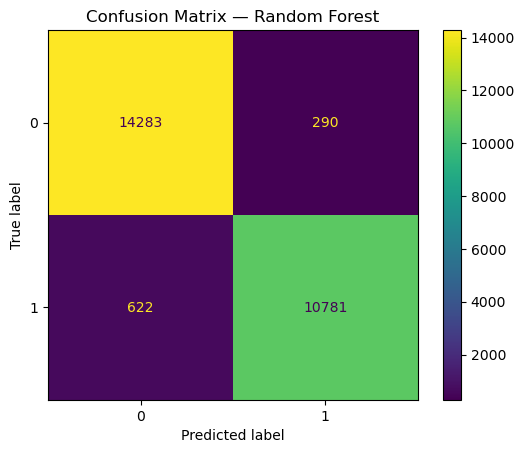

In [11]:
best_name = results_df.iloc[0]["model"]
best_model = models[best_name]
best_model.fit(X_train, y_train)

proba = best_model.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print("Best model:", best_name)
print("Accuracy:", accuracy_score(y_test, pred))
print("ROC AUC:", roc_auc_score(y_test, proba))
print("\nClassification report:")
print(classification_report(y_test, pred, digits=3))

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"Confusion Matrix — {best_name}")
plt.show()


## Best model deep dive: classification report and confusion matrix

The top-performing model from the holdout evaluation is selected and re-fit on the full training split, then evaluated on the holdout test split using probability-based predictions (`predict_proba`) with a default threshold of **0.50**.

### Best model
- **Model:** Random Forest  
- **Accuracy:** **0.9649**  
- **ROC-AUC:** **0.9944**

This indicates excellent overall discrimination between the two classes:
- **0 = neutral or dissatisfied**
- **1 = satisfied**

### Classification report (holdout test)
- **Class 0 (neutral or dissatisfied)**
  - Precision: **0.958**
  - Recall: **0.980**
  - F1-score: **0.969**
  - Support: **14,573**
- **Class 1 (satisfied)**
  - Precision: **0.974**
  - Recall: **0.945**
  - F1-score: **0.959**
  - Support: **11,403**

Overall:
- **Weighted F1:** **0.965**
- **Macro F1:** **0.964**

Interpretation:
- The model is slightly stronger at **recovering class 0** (higher recall for class 0).
- For class 1, precision is very high (few false positives), while recall is slightly lower than class 0 (some satisfied passengers are predicted as not satisfied).

### Confusion matrix interpretation
From the confusion matrix:

- **True negatives (0 → 0):** 14,283  
- **False positives (0 → 1):** 290  
- **False negatives (1 → 0):** 622  
- **True positives (1 → 1):** 10,781  

Operational interpretation:
- Only **290** neutral/dissatisfied passengers are incorrectly flagged as satisfied (low false-positive count).
- **622** satisfied passengers are missed (predicted as neutral/dissatisfied), representing the primary error mode.
- Threshold tuning can be used to adjust the tradeoff:
  - Lowering the threshold generally increases recall for class 1 (fewer missed satisfied cases) at the cost of more false positives.
  - Raising the threshold generally improves precision for class 1 (even fewer false positives) at the cost of recall.


### Feature importance (permutation)

Permutation importance estimates how much model performance decreases when a feature is randomly shuffled.
This provides an interpretable ranking of drivers (service ratings, delays, and profile attributes).


In [13]:
# --- Fix: permutation importance feature-name mismatch ---
# Root cause:
# - permutation_importance(best_model, X_pi, ...) returns importances for the *raw input columns* of X_pi
# - but feature_names was built from the *expanded* one-hot + numeric names, causing a length mismatch

import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance

# (Optional) only needed if transformed importance is computed
import scipy.sparse as sp

# Sample for speed while preserving signal
sample_n = min(20000, len(X_test))
X_pi = X_test.sample(sample_n, random_state=RANDOM_STATE)
y_pi = y_test.loc[X_pi.index]

# -------------------------
# A) Permutation importance at RAW-feature level (recommended)
# -------------------------
pi_raw = permutation_importance(
    best_model, X_pi, y_pi,
    n_repeats=5,
    random_state=RANDOM_STATE,
    scoring="roc_auc",
    n_jobs=-1
)

imp_raw = pd.DataFrame({
    "feature": X_pi.columns.to_numpy(),
    "importance_mean": pi_raw.importances_mean,
    "importance_std": pi_raw.importances_std,
}).sort_values("importance_mean", ascending=False)

print("RAW-feature permutation importance (top 20):")
display(imp_raw.head(20))

# -------------------------
# B) (Optional) Permutation importance at TRANSFORMED-feature level (one-hot expanded)
#    This breaks categorical features into individual one-hot categories.
# -------------------------
pre = best_model.named_steps["preprocess"]
final_est = best_model.named_steps["model"]

X_pi_t = pre.transform(X_pi)

# Convert sparse -> dense (safe here because transformed width is small in this dataset)
if sp.issparse(X_pi_t):
    X_pi_t = X_pi_t.toarray()

pi_tx = permutation_importance(
    final_est, X_pi_t, y_pi,
    n_repeats=5,
    random_state=RANDOM_STATE,
    scoring="roc_auc",
    n_jobs=-1
)

# Get transformed feature names
try:
    feature_names_tx = pre.get_feature_names_out()
except Exception:
    # Fallback: build names manually if get_feature_names_out is not available
    # (raw fallback is already provided above)
    feature_names_tx = np.array([f"f_{i}" for i in range(X_pi_t.shape[1])])

# Sanity check to avoid the same error
assert len(feature_names_tx) == len(pi_tx.importances_mean), (
    f"Length mismatch: names={len(feature_names_tx)} vs importances={len(pi_tx.importances_mean)}"
)

imp_tx = pd.DataFrame({
    "feature": feature_names_tx,
    "importance_mean": pi_tx.importances_mean,
    "importance_std": pi_tx.importances_std,
}).sort_values("importance_mean", ascending=False)

print("TRANSFORMED-feature permutation importance (top 30):")
display(imp_tx.head(30))


RAW-feature permutation importance (top 20):


,feature,importance_mean,importance_std
4,Type of Travel,0.085468,0.001043
7,Inflight wifi service,0.061251,0.000905
2,Customer Type,0.025921,0.000706
12,Online boarding,0.007985,0.000144
5,Class,0.005599,0.000122
18,Checkin service,0.004651,0.000216
13,Seat comfort,0.004169,0.000110
17,Baggage handling,0.004049,0.000136
19,Inflight service,0.003933,0.000123
20,Cleanliness,0.003258,0.000098


TRANSFORMED-feature permutation importance (top 30):


,feature,importance_mean,importance_std
12,num__Inflight wifi service,0.061251,0.000905
5,cat__Type of Travel_Personal Travel,0.008678,0.000186
17,num__Online boarding,0.007985,0.000144
4,cat__Type of Travel_Business travel,0.006793,0.000149
23,num__Checkin service,0.004651,0.000216
18,num__Seat comfort,0.004169,0.000110
22,num__Baggage handling,0.004049,0.000136
24,num__Inflight service,0.003933,0.000123
3,cat__Customer Type_disloyal Customer,0.003477,0.000087
2,cat__Customer Type_Loyal Customer,0.003470,0.000076


## Model explainability: permutation importance (ROC-AUC)

Permutation importance measures how much model performance (here: **ROC-AUC**) drops when a feature is randomly shuffled. A larger drop indicates higher importance. Two views are reported:

- **Raw-feature importance:** importance at the original column level (best for business interpretation).
- **Transformed-feature importance:** importance after preprocessing (one-hot + scaling), which splits categorical variables into individual category indicators.

---

### A) Raw-feature permutation importance (top drivers)

Top contributors to ROC-AUC (highest to lowest):

1. **Type of Travel** (0.0855 ± 0.0010)  
2. **Inflight wifi service** (0.0613 ± 0.0009)  
3. **Customer Type** (0.0259 ± 0.0007)  
4. **Online boarding** (0.0080 ± 0.0001)  
5. **Class** (0.0056 ± 0.0001)  
6. **Checkin service** (0.0047 ± 0.0002)  
7. **Seat comfort** (0.0042 ± 0.0001)  
8. **Baggage handling** (0.0040 ± 0.0001)  
9. **Inflight service** (0.0039 ± 0.0001)  
10. **Cleanliness** (0.0033 ± 0.0001)

Additional notes:
- **Arrival Delay in Minutes** shows relatively low incremental importance (~0.00049), suggesting that in this dataset, **service ratings and passenger/travel context dominate satisfaction prediction**.
- `id` appears with non-zero importance. Since `id` is an identifier rather than a business feature, it is typically removed in production pipelines to avoid accidental spurious signal.

---

### B) Transformed-feature permutation importance (after one-hot encoding)

This view decomposes categorical fields into specific categories:

- **num__Inflight wifi service** remains the top numeric driver (0.0613 ± 0.0009).
- `Type of Travel` splits into:
  - **cat__Type of Travel_Personal Travel** (0.00868 ± 0.00019)
  - **cat__Type of Travel_Business travel** (0.00679 ± 0.00015)
- Strong service drivers are consistent with the gap analysis:
  - **num__Online boarding** (0.00799 ± 0.00014)
  - **num__Checkin service** (0.00465 ± 0.00022)
  - **num__Seat comfort** (0.00417 ± 0.00011)
  - **num__Baggage handling** (0.00405 ± 0.00014)
  - **num__Inflight service** (0.00393 ± 0.00012)
  - **num__Cleanliness** (0.00326 ± 0.00010)

---

### Key takeaway
Across both views, **travel context** (Type of Travel, Customer Type, Class) and **service experience signals** (wifi, online boarding, comfort, check-in, cleanliness) are the strongest differentiators of satisfaction, while **delay metrics contribute less incremental lift** once service ratings are included.


## 8) Delay risk scoring (operational proxy)

Operational risk scoring can be framed as a binary classification problem:
- **On-time risk:** arrival delay > 15 minutes
- **Severe-delay risk:** arrival delay ≥ 60 minutes

This section trains a simple model for severe delay risk. The same pattern applies to other thresholds.


In [14]:
# Target: severe delay (>= 60 minutes)
#
# Important note on leakage:
# - The label is computed from Arrival Delay in Minutes.
# - Including Arrival Delay in Minutes as an input feature would make the task trivial.
# - Two realistic variants are shown:
#   A) Pre-flight proxy: exclude both delay fields (uses profile + service ratings as available in the dataset)
#   B) At-gate/in-flight proxy: include Departure Delay in Minutes, exclude Arrival Delay in Minutes

y_delay = train_c["severe_delay_60"].astype(int)

base_drop = ["satisfaction", "satisfaction_bin", "severe_delay_60", "otp_arrival_15", "delay_anomaly"]
available_cols = [c for c in train_c.columns if c not in base_drop]

# Variant A: Pre-flight proxy (no delay minutes)
X_a = train_c[available_cols].drop(columns=["Departure Delay in Minutes", "Arrival Delay in Minutes"], errors="ignore")

# Variant B: At-gate/in-flight proxy (departure delay known, arrival delay excluded)
X_b = train_c[available_cols].drop(columns=["Arrival Delay in Minutes"], errors="ignore")

def train_eval_delay_model(X, y, title):
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    cat_cols = [c for c in X_tr.columns if X_tr[c].dtype == "object"]
    num_cols = [c for c in X_tr.columns if X_tr[c].dtype != "object"]

    preprocess = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
            ("num", Pipeline(steps=[("scaler", StandardScaler())]), num_cols),
        ],
        remainder="drop"
    )

    model = Pipeline(
        steps=[
            ("preprocess", preprocess),
            ("clf", LogisticRegression(max_iter=2000))
        ]
    )

    model.fit(X_tr, y_tr)
    proba = model.predict_proba(X_te)[:, 1]
    pred = (proba >= 0.5).astype(int)

    print(title)
    print("Accuracy:", accuracy_score(y_te, pred))
    print("ROC AUC:", roc_auc_score(y_te, proba))
    print(classification_report(y_te, pred, digits=3))
    print("-" * 80)

train_eval_delay_model(X_a, y_delay, "Variant A — Severe-delay risk (pre-flight proxy)")
train_eval_delay_model(X_b, y_delay, "Variant B — Severe-delay risk (at-gate/in-flight proxy)")


Variant A — Severe-delay risk (pre-flight proxy)
Accuracy: 0.9279149222847793
ROC AUC: 0.5709107761583891
              precision    recall  f1-score   support

           0      0.928     1.000     0.963     19283
           1      0.000     0.000     0.000      1498

    accuracy                          0.928     20781
   macro avg      0.464     0.500     0.481     20781
weighted avg      0.861     0.928     0.893     20781

--------------------------------------------------------------------------------


/Users/user/miniforge3/envs/r2c-dl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/user/miniforge3/envs/r2c-dl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/user/miniforge3/envs/r2c-dl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

Variant B — Severe-delay risk (at-gate/in-flight proxy)
Accuracy: 0.9822915162889178
ROC AUC: 0.9852949189733661
              precision    recall  f1-score   support

           0      0.987     0.994     0.990     19283
           1      0.920     0.826     0.871      1498

    accuracy                          0.982     20781
   macro avg      0.953     0.910     0.931     20781
weighted avg      0.982     0.982     0.982     20781

--------------------------------------------------------------------------------


## Severe-delay risk modeling (≥ 60 minutes) with leakage-aware feature sets

This section reframes the problem from satisfaction prediction to **operational risk forecasting**: predicting whether a flight will experience a **severe arrival delay** (defined as `Arrival Delay in Minutes ≥ 60`).

### Why leakage matters
The target label (`severe_delay_60`) is computed directly from **Arrival Delay in Minutes**.  
Including `Arrival Delay in Minutes` as an input feature would make the task trivial and unrealistic.

To keep the modeling aligned with real-world availability of information, two variants are defined:

- **Variant A — Pre-flight proxy:** excludes both delay fields  
  (uses passenger/trip context and service ratings available in the dataset)
- **Variant B — At-gate / in-flight proxy:** includes **Departure Delay in Minutes**, excludes **Arrival Delay in Minutes**  
  (reflects a scenario where departure delay is known before arrival)

---

## Variant A — Severe-delay risk (pre-flight proxy)

**Results**
- Accuracy: **0.9279**
- ROC-AUC: **0.5709**

**Classification report highlights**
- Class 0 (not severe delay): Recall **1.000**
- Class 1 (severe delay): Precision **0.000**, Recall **0.000** (no positive predictions)

**Interpretation**
- Despite high accuracy, the model effectively predicts **only the majority class** (no severe delay).
- The severe-delay class is relatively rare (support ≈ 1,498 out of 20,781), so accuracy can be misleading.
- ROC-AUC near **0.57** indicates weak discrimination when delay minutes are unavailable.
- The warnings (`UndefinedMetricWarning`) occur because the model produced **zero predicted positives**, making precision undefined.

**Operational takeaway**
- With only passenger/service survey features (and no operational delay signals), this dataset provides **limited predictive signal** for severe delay risk. This is expected because severe delay is primarily operational and network-driven.

---

## Variant B — Severe-delay risk (at-gate/in-flight proxy)

**Results**
- Accuracy: **0.9823**
- ROC-AUC: **0.9853**

**Classification report highlights**
- Class 0 (not severe delay): Precision **0.987**, Recall **0.994**
- Class 1 (severe delay): Precision **0.920**, Recall **0.826**, F1 **0.871**

**Interpretation**
- Including **Departure Delay in Minutes** dramatically improves performance.
- A ROC-AUC near **0.99** indicates very strong separation: departure delay carries substantial forward-looking signal for whether the flight will ultimately be severely delayed at arrival.
- The main error mode is **missed severe delays** (recall 0.826), which is often acceptable or tunable depending on operational preference.

**Operational takeaway**
- Once departure delay is observed, severe-delay risk becomes highly predictable in this dataset.
- In practice, threshold tuning can be used to trade off:
  - higher recall (catch more severe delays) vs.
  - higher precision (reduce false alarms)

---

### Summary
- **Pre-flight (no delay minutes):** weak discrimination; accuracy inflated by class imbalance.
- **At-gate/in-flight (departure delay known):** strong predictive performance and operationally actionable risk scoring.


## 9) Executive-style findings (data-backed summary)

This section consolidates the notebook’s outputs into a concise set of findings that align with common airline operational and service-delivery questions.

- **Operational performance (reliability snapshot):**  
  Overall OTP (arrival ≤ 15 minutes) is **~77.3%**, with an average arrival delay of **~15.1 minutes** and a severe-delay (arrival ≥ 60 minutes) rate of **~7.2%**.  
  The delay distribution is **right-skewed**: most flights cluster near on-time performance, while a smaller set of disruptions drives a long tail of high delay minutes.

- **Chronic segments (where tail-risk concentrates):**  
  Median arrival delay is **0 minutes** across major segments (Class, Type of Travel, Customer Type), indicating that separation occurs mainly in the **upper tail** rather than the “typical” case.  
  Tail-risk differences are visible in **p90 delays** and severe-delay rates. The interaction view (**Class × Type of Travel**) is most informative:
  - **Eco + Business travel** and **Eco Plus + Business travel** show the highest tail-risk (p90 ≈ **50 minutes**) and the weakest OTP (~**0.75**).  
  These segment “hotspots” are practical starting points for deeper operational investigations (e.g., schedule padding, rotation effects, station performance).

- **Service delivery (experience gaps that matter):**  
  Average service ratings cluster around mid-to-high values, but the more diagnostic view is the **satisfaction gap** (mean rating difference between satisfied vs. neutral/dissatisfied).  
  The largest gaps—and therefore the clearest satisfaction differentiators—are:
  - **Online boarding (+1.37)**  
  - **Inflight entertainment (+1.07)**  
  - **Seat comfort (+0.93)**  
  followed by onboard service, leg room service, cleanliness, and inflight wifi.  
  These dimensions represent high-leverage opportunities because they separate the two outcome groups most strongly.

- **Drivers of satisfaction (model-based ranking):**  
  A Random Forest achieves strong holdout performance (**Accuracy ~0.965**, **ROC-AUC ~0.994**), confirming that the dataset contains high signal for predicting satisfaction.  
  Permutation importance highlights the strongest contributors at the raw-feature level:
  - **Type of Travel**, **Inflight wifi service**, **Customer Type**, **Online boarding**, and **Class** (followed by check-in, seat comfort, baggage handling, inflight service, cleanliness).  
  Operational delay fields contribute less incremental lift in this dataset once service ratings and travel context are included.

- **Risk scoring (severe-delay classification, leakage-aware):**  
  Severe delay prediction (arrival ≥ 60 minutes) is evaluated in two realistic variants:
  - **Pre-flight proxy (no delay minutes):** weak discrimination (**ROC-AUC ~0.57**) and the model defaults to the majority class due to class imbalance.  
  - **At-gate/in-flight proxy (departure delay known, arrival delay excluded):** strong discrimination (**ROC-AUC ~0.985**) with meaningful detection of severe delays (class 1 recall **~0.83**).  
  This demonstrates that **departure delay** is a highly informative operational signal for downstream severe-delay risk.

**Extensibility note:**  
The notebook is intentionally modular. If additional operational fields become available (e.g., cancellations/diversions, delay causes, airport/route identifiers, time-of-day, aircraft rotation), the chronic-segment logic, anomaly detection, and risk scoring can be extended into a more complete operational performance and service-delivery monitoring pipeline.
